<a href="https://colab.research.google.com/github/blackcaer/SMF-training/blob/main/SMFv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Initializing
from google.colab import drive
drive.mount('/content/drive/')

!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd  # https://github.com/microsoft/LightGBM/issues/5914

!pip install lightgbm --config-settings=cmake.define.USE_GPU=ON

!pip install scikit-optimize

import lightgbm as lgb
from IPython.display import display

import os
import json
#import time
import gc
import random
import psutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback

from datetime import datetime
from functools import partial

from google.colab import files
from sys import getsizeof
from time import time
import pprint
import joblib

from collections import defaultdict, Counter
from itertools import combinations

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,median_absolute_error  #mean_squared_error
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

from scipy.fftpack import fft
from scipy.stats import zscore

import plotly.graph_objects as go

!pip install optuna
!pip install optuna-integration[lightgbm]
import optuna
from optuna.integration import LightGBMPruningCallback

from torch.cuda import get_device_name,is_available
#from os import cpu_count

#print(f"Liczba rdzeni procesora: {cpu_count()} (realnych 2x mniej prawdopodobnie)")
gpu_available = is_available()

if gpu_available:
    print("GPU avalibe.")
    print("Name of GPU:", get_device_name(0))
else:
    print("GPU is not avalibe.")
_features_added=False


Mounted at /content/drive/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 4.1 MB/s eta 0:00:00
GPU is not avalibe.


In [3]:
#@title Constants

ITEMS_PHSM_JSON = '/content/drive/My Drive/SMF_files/items_phsm.json'
ITEMS_PHSM_JSON_TEST = '/content/drive/My Drive/SMF_files/items_phsm_test.json'

PLAYER_COUNT_JSON = '/content/drive/My Drive/SMF_files/rust_player_count_interpolated.json'

SPIKES_TH=2
SPIKES_TH_TEST=1.5
SPIKES_PATH='/content/drive/My Drive/SMF_files/spikes_correction.csv'
SPIKES_PATH_TEST='/content/drive/My Drive/SMF_files/spikes_correction_test.csv'

MODEL_SAVES_PATH='/content/drive/MyDrive/SMF_files/model_saves'
OPT_SAVES_PATH="/content/drive/MyDrive/SMF_files/opt_saves/"

ITEMS_TO_EXCLUDE=['Metal Tree Door',]#'No Mercy Revolver - E Class','Neon Dragon Garage Door','Zipper Face'] # 'Metal Tree Door' - one of the rarest items in the game, very few sales since 2018

In [4]:
#@title Params
TEST_MODE = 0
MAKE_SPIKES_CORR_FILE=0

In [5]:
#@title Helpers
def get_learning_summary(y_pred_train, y_train, y_pred_test, y_test, y_pred_naive, label="[no label]"):
  """ Returns dataframe with metrics"""

  results = {
      "Metric": ["Accuracy", "RMSE", "MAE", "MAPE", "Max Error", "Median Absolute Error"],
      "Train": calc_accuracy(y_pred_train, y_train, "Train accuracy:"),
      "Valid": calc_accuracy(y_pred_test, y_test, "Validation accuracy:"),
      "Naive": calc_accuracy(y_pred_naive, y_test, "Naive accuracy:")
  }

  #display(df)
  return pd.DataFrame(results)

def calc_accuracy(pred, actual, label=""):
  """ Returns accuracy metrics: accuracy, rmse, mae, mape, max_error, median_absolute_error """
  N=3
  errors = np.abs(pred - actual)
  accuracy = round(100 * (1 - np.mean(errors / actual)), N)
  max_error = round(np.max(errors), N)
  std_deviation = round(np.std(errors), N)
  mae = round(np.mean(errors), N)
  median_absolute_error = round(np.median(errors), N)
  mape = round(mean_absolute_percentage_error(actual, pred), N)
  rmse = round(root_mean_squared_error(actual, pred), N)

  return accuracy, rmse, mae, mape, max_error, median_absolute_error

def print_importances(model,start=0,print_tab=False,name="",figsize=(10, 18),importance_type='gain',end=-1):
  importance = model.feature_importance(importance_type=importance_type)  # 'split' lub 'gain'
  feature_names = model.feature_name()

  trim=0
  importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
  importance_df = importance_df.sort_values(by='Importance', ascending=False)[start:end]

  # Wizualizacja
  print(f"Trimmed first {trim} features to see better")
  plt.figure(figsize=figsize)
  plt.barh(importance_df['Feature'], importance_df['Importance'])
  plt.xlabel('Importance')
  plt.title(f'Feature Importance {name}')
  plt.style.use('dark_background')
  plt.gca().invert_yaxis()
  plt.show()
  pd.set_option('display.max_rows', None)
  if print_tab:
    display(importance_df)

def aggregate_pricehistories(pricehistories):
    interpolated_histories = []
    max_date = max(df.index.max() for df in pricehistories)
    for df in pricehistories:
        df_resampled = df.resample('D').interpolate(method='linear')
        full_date_range = pd.date_range(start=df_resampled.index.min(), end=max_date, freq='D')
        df_reindexed = df_resampled.reindex(full_date_range)
        df_filled = df_reindexed.ffill()

        interpolated_histories.append(df_filled)

    all_data = pd.concat(interpolated_histories)

    sum = all_data.groupby(all_data.index).sum()
    med = all_data.groupby(all_data.index).median()
    mean = all_data.groupby(all_data.index).mean()

    plot_pricehistory([med[:],mean[:]],['med','mean'],"Test")
    plot_pricehistory([sum[:]],['sum'],"Test",1)
    return sum,med,mean

def col_from_idx(df,idx_name,pos=None):
  df[idx_name] = df.index.get_level_values(idx_name)
  if pos is not None:
    cols = df.columns.tolist()
    cols.insert(pos, cols.pop(cols.index(idx_name)))
    df = df[cols]

def rmse_top_items_analysis(y_actual,y_pred,data_mapped,show_top_items=False):
  squared_errors = np.power(np.abs(y_actual - y_pred),2)

  data_mapped_with_errors = data_mapped.assign(squared_error=squared_errors.values)
  avg_rmse_per_item = np.sqrt(data_mapped_with_errors.groupby('name')['squared_error'].mean())

  top_item_rmse = avg_rmse_per_item.nlargest(10)
  if show_top_items:
    print("Top items with largest rmse:")
    print(top_item_rmse)

  items_to_exclude = top_item_rmse.index
  mask = ~data_mapped.index.get_level_values('name').isin(items_to_exclude)

  filtered_data_mapped = data_mapped[mask]
  filtered_y_actual = y_actual[mask]
  filtered_y_pred = y_pred[mask]
  rmse_without_top_items = root_mean_squared_error(filtered_y_actual, filtered_y_pred)
  rmse_normal = root_mean_squared_error(y_actual, y_pred)
  print(f'\nRMSE without top items: {rmse_without_top_items:.4f} (Change {(rmse_without_top_items/rmse_normal-1)*100:.2f}%)\n')
  return top_item_rmse

def plot_pricehistory(pricehistories: list, labels: list, title, day_interval=30, relative_x_axis=False, figsize=(16, 6)):
    fig = go.Figure()

    for i in range(len(pricehistories)):
        if relative_x_axis:
            days_from_start = (pricehistories[i].index - pricehistories[i].index[0]).days

            fig.add_trace(go.Scatter(
                x=days_from_start,
                y=pricehistories[i].values,
                mode='lines',
                name=labels[i]
            ))
        else:
            fig.add_trace(go.Scatter(
                x=pricehistories[i].index,
                y=pricehistories[i].values,
                mode='lines',
                name=labels[i]
            ))

    if relative_x_axis:
        fig.update_xaxes(title_text='Days from Start', tickvals=days_from_start[::day_interval])
    else:
        fig.update_xaxes(title_text='Date', tickformat='%Y-%m-%d', dtick=f'{day_interval*86400000}')  # dtick w milisekundach

    fig.update_yaxes(title_text='Price')

    fig.update_layout(
        title=title,
        xaxis=dict(
            tickangle=45,
            showgrid=True,
            gridcolor='gray',
            gridwidth=0.5
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='gray',
            gridwidth=0.5
        ),
        template='plotly_dark',
        legend=dict(
            x=0.01, y=0.99,
            bordercolor="Black",
            borderwidth=1
        ),
        autosize=False,
        width=figsize[0] * 100, height=figsize[1] * 100
    )

    fig.show()


def plot_predictions_vs_actuals(test_dataset, predictions, item_name,label_main="",label1='real',label2='pred'):
  item_data = test_dataset.xs(item_name, level='name',drop_level=False)

  if len(item_data)==0:
    print(f"{item_name} is not in given data")
    return

  item_actuals = item_data['price']
  item_predictions = predictions[item_data.index]

  plot_df = pd.DataFrame({'date': item_data.index.get_level_values('date'), 'actual': item_actuals, 'predicted': item_predictions})

  rmse = root_mean_squared_error(item_actuals, item_predictions)

  print(f'RMSE {item_name}: {rmse}')

  plt.style.use('dark_background')
  plt.figure(figsize=(12, 6))
  plt.plot(plot_df['date'], plot_df['actual'], label=label1)
  plt.plot(plot_df['date'], plot_df['predicted'], label=label2)

  plt.xticks(rotation=45)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title(f'{item_name}: {label_main} {label1} vs {label2}')
  plt.legend()
  plt.show()


"""reducing.py
Author: Kirgsn, 2018
"""
from joblib import Parallel, delayed
from fastprogress import master_bar, progress_bar

def measure_time_mem(func):
    def wrapped_reduce(self, df, *args, **kwargs):
        # pre
        mem_usage_orig = df.memory_usage().sum() / self.memory_scale_factor
        start_time = time()
        # exec
        ret = func(self, df, *args, **kwargs)
        # post
        mem_usage_new = ret.memory_usage().sum() / self.memory_scale_factor
        end_time = time()
        print(f'reduced df from {mem_usage_orig:.4f} MB '
              f'to {mem_usage_new:.4f} MB '
              f'in {(end_time - start_time):.2f} seconds')
        gc.collect()
        return ret
    return wrapped_reduce


class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe into, in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None, use_categoricals=True, n_jobs=-1):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        :param use_categoricals: Whether the new pandas dtype "Categoricals"
                shall be used
        :param n_jobs: Parallelization rate
        """

        self.conversion_table = \
            conv_table or {'int': [np.int8, np.int16, np.int32, np.int64],
                           'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                           'float': [np.float32, ]}
        self.null_int = {   np.int8:  pd.Int8Dtype,
                            np.int16: pd.Int16Dtype,
                            np.int32: pd.Int32Dtype,
                            np.int64: pd.Int64Dtype,
                            np.uint8: pd.UInt8Dtype,
                            np.uint16:pd.UInt16Dtype,
                            np.uint32:pd.UInt32Dtype,
                            np.uint64:pd.UInt64Dtype}

        self.use_categoricals = use_categoricals
        self.n_jobs = n_jobs

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    @measure_time_mem
    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=self.n_jobs, max_nbytes=None)(progress_bar(list(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)))
        del df
        gc.collect()
        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):
        try:
            isnull = False
            # skip NaNs
            if s.isnull().any():
                isnull = True
            # detect kind of type
            coltype = s.dtype
            if np.issubdtype(coltype, np.integer):
                conv_key = 'int' if s.min() < 0 else 'uint'
            elif np.issubdtype(coltype, np.floating):
                conv_key = 'float'
                asint = s.fillna(0).astype(np.int64)
                result = (s - asint)
                result = np.abs(result.sum())
                if result < 0.01:
                    conv_key = 'int' if s.min() < 0 else 'uint'
            else:
                if isinstance(coltype, object) and self.use_categoricals:
                    # check for all-strings series
                    if s.apply(lambda x: isinstance(x, str)).all():
                        if verbose: print(f'convert {colname} to categorical')
                        return s.astype('category')
                if verbose: print(f'{colname} is {coltype} - Skip..')
                return s
            # find right candidate
            for cand, cand_info in self._type_candidates(conv_key):
                if s.max() <= cand_info.max and s.min() >= cand_info.min:
                    if verbose: print(f'convert {colname} to {cand}')
                    if isnull:
                        return s.astype(self.null_int[cand]())
                    else:
                        return s.astype(cand)

            # reaching this code is bad. Probably there are inf, or other high numbs
            print(f"WARNING: {colname} doesn't fit the grid with \nmax: {s.max()} "
                f"and \nmin: {s.min()}")
            print('Dropping it..')
        except Exception as ex:
            print(f'Exception for {colname}: {ex}')
            return s

def reduce_mem_usage(df):
  return Reducer().reduce(df)

In [6]:
#@title DataPrepper
class DataPrepper:
    def __init__(self):
        self.val_df = None
        self.train_df = None
        self.items_phsm_df = None
        self.rust_player_count_df = None
        self.dataset: pd.DataFrame = None
        self.columns_to_drop = [
            'previewUrl', 'views', 'timeCreated', 'timeRefreshed', 'isAvailableOnStore', 'creatorName',
            'appId',
            'id', 'nameId','hasGlow', 'hasCutout','timeAccepted'] # 'hasGlow', 'hasCutout' - no gain, no splits
        self.desired_column_order = ['date', 'price', 'volume', 'name', 'playerCount', 'supplyTotalEstimated',
                                     'storePrice',
                                     'glowRatio',  'cutoutRatio', 'hasGlowSights', 'facepunchSkin',
                                     'itemType',
                                     'itemCollection',
                                     ]

    def load_data(self):
        """
        Loads self.items_phsm_df and self.rust_player_count_df from files.
        """
        with open(ITEMS_PHSM_JSON if not TEST_MODE else ITEMS_PHSM_JSON_TEST, 'r') as f:
            items_phsm = json.load(f)

        with open(PLAYER_COUNT_JSON, 'r') as f:
            rust_player_count_json = json.load(f)

        items_phsm = [item for item in items_phsm if item['name'] not in ITEMS_TO_EXCLUDE]

        phsm_records = self.unfold_phsm(items_phsm)

        self.items_phsm_df = pd.DataFrame(phsm_records)

        self.rust_player_count_df = pd.DataFrame(rust_player_count_json)

        print("Loaded")

    def preprocess_data(self):
        """
        Prepares, merges data and assigns it to self.dataset
        """

        self.prep_player_count()
        self.prep_items_phsm()

        merged_df = pd.merge(self.items_phsm_df, self.rust_player_count_df, on='date',
                             how='left')

        ordered_df = merged_df.reindex(columns=self.desired_column_order)

        self.dataset = ordered_df

    @staticmethod
    def unfold_phsm(items_phsm):
        phsm_records = []
        for item in items_phsm:
            for phsm_entry in item['phsm']:
                record = {k: v for k, v in item.items() if k != 'phsm'}
                record.update(phsm_entry)
                phsm_records.append(record)
        return phsm_records

    def prep_player_count(self):
        self.rust_player_count_df = self.rust_player_count_df.rename(columns={'Date': 'date'})
        self.rust_player_count_df = self.rust_player_count_df.rename(columns={'Player_count': 'playerCount'})
        self.rust_player_count_df['date'] = pd.to_datetime(self.rust_player_count_df['date'])

        return self.rust_player_count_df

    def prep_items_phsm(self):
        self.items_phsm_df.rename(columns={'median': 'price'},inplace=True)
        self.items_phsm_df['date'] = pd.to_datetime(self.items_phsm_df['date'])
        self.items_phsm_df['timeAccepted'] = pd.to_datetime(self.items_phsm_df['timeAccepted'], errors='coerce')
        self.items_phsm_df['date'] = pd.to_datetime(self.items_phsm_df['date'])
        self.items_phsm_df.drop(columns=self.columns_to_drop,inplace=True)  # Delete unnecessary columns
        self.items_phsm_df = self.items_phsm_df.sort_values(by=['name', 'date'])


        self.items_phsm_df.reset_index(drop=True)

    @staticmethod
    def add_features(dataset,change_original=False):
        raise NotImplementedError("Run window with add_features implementation first") #Add features is often changed so it's implemented in other window so I don't have to create new object every time i change it



In [73]:
#@title Helpers 2
def split_dataset(X, y, test_size):

    X.sort_index(level='date', inplace=True)
    y.sort_index(level='date', inplace=True)

    split_index = int(len(X) * (1 - test_size))

    train_idx, test_idx = np.arange(0, split_index), np.arange(split_index, len(X))

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    return X_train, X_test, y_train, y_test

def get_model_postfix(test_metrics,addidional_info=""):
  mae = test_metrics[test_metrics['Metric'] == 'MAE'].iloc[0, 1]    # Test dataset
  mape = test_metrics[test_metrics['Metric'] == 'MAPE'].iloc[0, 1]  # Test dataset
  median_ae = test_metrics[test_metrics['Metric'] == 'Median Absolute Error'].iloc[0, 2]  # Test dataset
  nmape = test_metrics[test_metrics['Metric'] == 'MAPE'].iloc[0, 2] # Naive mape
  return f"NMAPE{round(nmape * 1000)}MAE{round(mae * 1000)}MedAE{round(median_ae * 1000)}MAPE{round(mape * 1000)}{addidional_info}"

def autosave_model(model,name="lgbm_af",postfix=""):
  # DATASET_DATA - globally set contant with data about dataset
  try:
    folder_path=MODEL_SAVES_PATH
    curr_time = datetime.now().strftime('%Y-%m-%d_%H-%M')
    file_path = os.path.join(folder_path, f"{name}_{DATASET_DATA}_{curr_time}_{postfix}.txt")
    model.save_model(file_path)
  except Exception as e:
    print(f"Error saving model: {e}")
    traceback.print_exc()

def autosave_optimizer(opt):
  try:
    folder_path=OPT_SAVES_PATH
    curr_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file_path = os.path.join(folder_path, f"bayesian_optimizer_TEST{TEST_MODE}_{curr_time}.txt")
    joblib.dump(opt, file_path)
  except Exception as e:
    print(f"Error saving optimizer: {e}")
    traceback.print_exc()

def show_bayesian_results(opt,better_than=0.5):
  try:
    cv_results_df = pd.DataFrame(opt.cv_results_)
    print(cv_results_df.columns)

    score_column = 'mean_test_score'

    hyperparameters = ['param_colsample_bytree', 'param_learning_rate', 'param_max_bin',
                      'param_max_depth', 'param_min_child_samples', 'param_min_split_gain',
                       'param_num_leaves', 'param_reg_alpha',
                      'param_reg_lambda', 'param_subsample', 'param_subsample_freq']

    cv_results_df.sort_values(by=score_column, ascending=False, inplace=True)
    threshold = cv_results_df['mean_test_score'].quantile(better_than)
    cv_results_df = cv_results_df[cv_results_df['mean_test_score'] >= threshold]

    print(f"{len(cv_results_df)} qualifying records")
    for param in hyperparameters:
        plt.figure(figsize=(10, 6))

        if param in ['param_min_split_gain', 'param_reg_alpha', 'param_reg_lambda', 'param_learning_rate']:
            plt.xscale('log')

        sns.regplot(data=cv_results_df, x=param, y=score_column, lowess=True, scatter_kws={'s': 20})

        plt.title(f'Zależność wyniku (metryki) od {param}')
        plt.xlabel(param)
        plt.ylabel('Mean Test Score (MAE)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()
  except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()

def create_naive_prediction(X_test,keys,verbose=True):
  """ keys - what column of X_test to use as prediction, for example price_lag1 """
  #if keys is None:
  #  keys=['price_lag1','price_lag2','price_lag3','storePrice']
  for key in keys:
    try:
      y_pred_naive = pd.Series(X_test[key].fillna(3).to_numpy(), index = X_test.index)  # there shouldn't be much nan's
      if verbose:
        print(f"Created naive prediction from {key}")
    except KeyError:
      continue
    else:
      break
  if y_pred_naive is None:
    raise RuntimeError("Assigning value to y_pred_naive failed. Check your X_test dataset. Checked keys: "+str(keys))
  return y_pred_naive

In [8]:
#@title Load

dp = DataPrepper()
dp.load_data()
dp.preprocess_data()

# reduce_mem_usage in other places fucks types up, doesn't give much and is slow
dp.items_phsm_df= reduce_mem_usage(dp.items_phsm_df)
dp.rust_player_count_df = reduce_mem_usage(dp.rust_player_count_df)

display(dp.dataset.head())

Loaded


reduced df from 493.7952 MB to 246.9345 MB in 18.81 seconds


reduced df from 0.0607 MB to 0.0456 MB in 0.20 seconds


,date,price,volume,name,playerCount,supplyTotalEstimated,storePrice,glowRatio,cutoutRatio,hasGlowSights,facepunchSkin,itemType,itemCollection
0,2015-10-09,3.46,13,60's Army Jacket,18841,380,2.49,0.0,0.006949,False,False,Snow Jacket,Army
1,2015-10-10,3.72,15,60's Army Jacket,22166,380,2.49,0.0,0.006949,False,False,Snow Jacket,Army
2,2015-10-11,3.32,15,60's Army Jacket,22988,380,2.49,0.0,0.006949,False,False,Snow Jacket,Army
3,2015-10-12,3.26,8,60's Army Jacket,20250,380,2.49,0.0,0.006949,False,False,Snow Jacket,Army
4,2015-10-13,3.12,11,60's Army Jacket,17684,380,2.49,0.0,0.006949,False,False,Snow Jacket,Army


In [63]:
#@title def eval_models

def get_last_index_TSS(X,n_splits):
    """ Last test index from TimeSeriesSplit was never used for learning, only for validation.
        Returns that test index."""
    tscv = TimeSeriesSplit(n_splits)
    tscv.split(X)
    test_index=None
    for train_index_tmp, test_index_tmp in tscv.split(X):
        test_index=test_index_tmp
    return test_index

def eval_model(model,X,y,set_name,keys_naive):
    """ Evaluates model and returns dataframe with metrics. """
    pred = model.predict(X)
    pred_naive = create_naive_prediction(X,keys=keys_naive)

    results = {
      "Metric": ["Accuracy", "RMSE", "MAE", "MAPE", "Max Error", "Median Absolute Error"],
    }

    results[set_name] = calc_accuracy(pred, y, f"{set_name} accuracy:")
    results["Naive"] = calc_accuracy(pred_naive, y, "Naive accuracy:")

    return pd.DataFrame(results)


In [10]:
#@title Def add_features

def add_features(dataset,target_data):
  #target_data = {'window':TARGET_WINDOW,'lag':TARGET_LAG}
  target_window = target_data['window']
  target_lag = target_data['lag']

  to_interpolate = ['price', 'volume', 'playerCount']
  bool_columns = []#[ 'facepunchSkin', 'is_weekend']#'hasGlowSights','hasGlow', 'hasCutout',
  int_columns = ['year', 'month', 'day', 'volume', 'playerCount', 'supplyTotalEstimated', 'weekday']
  categorical_columns = ['itemType', 'itemCollection']

  columns_to_keep = ['price', 'volume', 'playerCount', 'supplyTotalEstimated', 'storePrice', 'itemType', 'itemCollection'] # , 'glowRatio', 'cutoutRatio', 'facepunchSkin'

  dataset = dataset[columns_to_keep]

  original_column_order = dataset.columns.tolist()

  # Interpolating data
  interpolated_data = dataset.groupby('name')[to_interpolate].apply(
      lambda group: group.reset_index('name', drop=True).asfreq('D').interpolate(method='linear'))

  not_interpolated_data = dataset.groupby('name')[dataset.columns.difference(to_interpolate)].apply(
      lambda group: group.reset_index('name', drop=True).asfreq('D'))

  dataset = pd.concat([interpolated_data, not_interpolated_data], axis=1)[original_column_order]

  def compute_features(group):
    lags_price = [1, 2, 3, 4, 5, 6, 7, 14, 21]+[28, 35]#[2, 3, 4, 5, 6, 7, 14, 21]
    lags_vol = [1, 2, 3, 7]#[1, 2, 3, 7]
    lags_player_count=[1,7,28]+[14,21]

    #lags_price_for_windows = [7,21,28] #TODO implement that

    windows_price = [3, 7, 14, 21]
    windows_volume = [3, 21] + [7,14]
    windows_player_count=[7,14] + [3]
    ewma_windows = [7, 14, 21, 30]

    features = {}

    for lag in lags_price:
      features[f'price_lag{lag}'] = group['price'].shift(lag)

    for lag in lags_vol:
      features[f'vol_lag{lag}'] = group['volume'].shift(lag)

    for lag in lags_player_count:
      lag=lag+1   # lag+1 because rolling takes current data too, that'd be a data leak
      for window in windows_player_count:

        if len(group)+lag >= window:  # Ensure enough data points for rolling operations
          roll = group[['playerCount']]['playerCount'].shift(lag).rolling(window=window)
          features[f'playerCount_roll_mean_{window}_lag_{lag-1}'] = roll.mean()
        else:
          features[f'playerCount_roll_mean_{window}_lag_{lag-1}'] = np.nan

    for window in windows_price:
      if len(group) >= window:  # Ensure enough data points for rolling operations
          roll = group[['price']].shift(1).rolling(window=window)
          features.update({
            f'price_roll_mean_{window}': roll['price'].mean(),
            f'price_roll_std_{window}': roll['price'].std(),
            f'price_roll_var_{window}': roll['price'].var(),
            f'price_roll_sum_{window}': roll['price'].sum(),
          })
      else:
        features.update({
            f'price_roll_mean_{window}': np.nan,
            f'price_roll_std_{window}':np.nan,
            f'price_roll_var_{window}':np.nan,
            f'price_roll_sum_{window}': np.nan,
        })

    for window in windows_volume:
      if len(group) >= window:  # Ensure enough data points for rolling operations
          roll = group[['volume']].shift(1).rolling(window=window)
          features.update({
            f'vol_roll_mean_{window}': roll['volume'].mean(),
          })
      else:
        features.update({
            f'vol_roll_mean_{window}': np.nan,
        })

    features['price_trend'] = np.arange(len(group)) * group['price'].shift(1).pct_change().fillna(0)
    features['volume_trend'] = np.arange(len(group)) * group['volume'].shift(1).pct_change().fillna(0)

    for window in ewma_windows:
      features[f'price_ewma_{window}'] = group['price'].shift(1).ewm(span=window, adjust=False).mean()
      #features[f'vol_ewma_{window}'] = group['volume'].shift(1).ewm(span=window, adjust=False).mean()

    features['price_cumsum'] = group['price'].shift(1).cumsum()
    features['volume_cumsum'] = group['volume'].shift(1).cumsum()

    collection_group = group.groupby('itemCollection',observed=True)

    for window in windows_price:
      if len(group) >= window:
        # Rolling mean for price and volume across the collections
        collection_rolling = collection_group[['price', 'volume']].shift(1).rolling(window=window)
        features.update({
            f'collection_price_roll_mean_{window}': collection_rolling['price'].mean(),
            f'collection_price_roll_std_{window}': collection_rolling['price'].std(),
            f'collection_price_roll_var_{window}': collection_rolling['price'].var(),
            f'collection_price_roll_sum_{window}': collection_rolling['price'].sum(),
        })
      else:
        features.update({
            f'collection_price_roll_mean_{window}': np.nan,
            f'collection_price_roll_std_{window}': np.nan,
            f'collection_price_roll_var_{window}': np.nan,
            f'collection_price_roll_sum_{window}': np.nan,
        })

    collection_mean = collection_group[['price', 'volume']].shift(1).expanding().mean()
    features['collection_price_mean'] = collection_mean['price']
    features['collection_vol_mean'] = collection_mean['volume']

    _target_price_roll_mean = group[['price']].shift(1).rolling(window=target_window)['price'].mean()
    features["target"] = _target_price_roll_mean.shift(-target_window-1).shift(-target_lag)

    return pd.concat([group, pd.DataFrame(features, index=group.index)], axis=1)

  dataset = dataset.groupby('name', group_keys=False).apply(compute_features)

  dates = dataset.index.get_level_values('date')
  dataset['year'] = dates.year
  dataset['month'] = dates.month
  dataset['day'] = dates.day
  dataset['weekday'] = dates.weekday
  dataset['is_weekend'] = (dataset['weekday'] >= 5)
  dataset['d_from_nyear'] = (dates - pd.to_datetime(dates.year.astype(str) + '-01-01')).days
  dataset['d_to_june'] = (pd.to_datetime(dates.year.astype(str) + '-06-01') - dates).days


  dataset[bool_columns] = dataset[bool_columns].astype(bool)
  dataset[int_columns] = dataset[int_columns].fillna(0).astype(int)
  dataset[categorical_columns] = dataset[categorical_columns].astype('category')

  dataset.dropna(subset=['itemType'], inplace=True)  # Drop interpolated rows, subset is whatever is not interpolated

  return dataset

dp.add_features = add_features


In [11]:
#@title Def prepare_datasets
DATASET_DATA=""
def prepare_datasets(dp,target_window=1,target_lag=0,test_size=0.15,columns_to_drop=None):
  # target window has to be also in windows_price in add_features
  # TARGET_LAG == X means that rolling mean is rolled after X+1 days from data point. If TARGET_LAG==0, mean is rolled starting on next day after data point.
  if columns_to_drop is None:
    columns_to_drop = []

  global DATASET_DATA
  DATASET_DATA=f"tw_{target_window}_tl{target_lag}"

  target_data = {'window':target_window,'lag':target_lag}
  dataset = dp.dataset.copy()
  dataset.set_index(['name', 'date'], inplace=True)
  dataset = dp.add_features(dataset,target_data)

  dataset.drop(columns=columns_to_drop,inplace=True)  # Drop less important features

  X_whole = dataset.drop(columns=['target'])
  y_whole = dataset["target"]

  # Fix indexes
  y_whole.dropna(inplace=True)
  X_whole = X_whole.loc[y_whole.index]

  X, X_test, y, y_test = split_dataset(X_whole,y_whole,test_size=test_size)
  del X_whole,y_whole
  return X, X_test, y, y_test

In [12]:
columns_to_drop = ['collection_price_roll_mean_7',
 'collection_price_roll_sum_7',
 'collection_price_roll_sum_14',
 'collection_price_roll_std_14',
 'price_lag14',
 'price_roll_var_14',
 'collection_price_roll_var_21',
 'collection_price_roll_var_14',
 'vol_lag1',
 'price_lag2',
 'price_lag4',
 'price_lag3']

In [13]:
X, X_test, y, y_test = prepare_datasets(dp,7,28,columns_to_drop=columns_to_drop)

In [ ]:
#@title Basic optuna

n_splits = 5
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
cv_strategy = list(TimeSeriesSplit(n_splits).split(X))

valid_idx = get_last_index_TSS(X, n_splits)
X_valid = X.iloc[valid_idx]
y_valid = y.iloc[valid_idx]
valid_lgb_dataset = lgb.Dataset(X_valid, label=y_valid, free_raw_data=False)

lgbdataset=lgb.Dataset(X, label=y, free_raw_data=False)

def objective(trial):
    param = {
        'boosting_type': 'gbdt',
        'objective': 'mae',
        'metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4,log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 896),
        'max_depth': trial.suggest_int('max_depth', -1, 256),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-10, 10.0,log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1000.0,log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 32, 512),
        'min_split_gain': trial.suggest_categorical('min_split_gain', [0.00001,0.0001,0.001,0.005,0.01,0.1,0.4,0.7,1,2]), # low impact on score
        'max_bin': trial.suggest_int('max_bin', 512, 5096),
        'seed': 40,
        'num_threads': -1,
        'device': 'gpu' if gpu_available else 'cpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'verbose': -1
    }

    cv_results = lgb.cv(
        param,
        lgbdataset,
        folds=cv_strategy,
        num_boost_round=800,
        return_cvbooster=False,
        callbacks=[LightGBMPruningCallback(trial, 'l1'),lgb.log_evaluation(period=100),
              lgb.early_stopping(stopping_rounds=200, min_delta=0.001)]
    )

    best_score = min(cv_results['valid l1-mean'])
    gc.collect()
    return best_score

def print_results(study):
  print('='*10)
  print(f"ITERATION {iter}\nBest parameters:")
  pprint.pprint(study.best_params)
  print(f"Best MAE score: {study.best_value:.3f}")
  print('='*10)

def configure_storage(study,study_name,storage_name):
  rdb_storage = optuna.storages.RDBStorage(url=storage_name)
  study._storage = rdb_storage
  study.study_name = study_name

def save_study(study_name,name):
  destination = "/content/drive/MyDrive/SMF_files/optuna_saves/"
  os.system(f"cp {study_name}.db {destination}{name}")


In [ ]:
#@title Optuna automated
STUDY_NAME=f"optuna_study_v3"
STORAGE_NAME = f"sqlite:///{STUDY_NAME}.db"


def foo(test_postfix,iters=1,n_trials=100,iter_timeout=60*60*1):
  for i in range(iters):
    iter = i+1
    print(f"Starting iteration {iter}:")
    try:
      study = optuna.create_study(direction='minimize',storage=STORAGE_NAME,study_name=STUDY_NAME, load_if_exists=True,pruner=optuna.pruners.MedianPruner(n_warmup_steps=40))

      configure_storage(study,STUDY_NAME,STORAGE_NAME)

      study.optimize(objective, n_trials=n_trials, timeout=iter_timeout, show_progress_bar=True,gc_after_trial=True)

      save_study(STUDY_NAME,f"study_{iter}.db"+test_postfix)

      print_results(study)
    except Exception as e:
      print('='*10+f"An error occurred during iteration {iter}: {e}")
      continue
  return study


In [ ]:
#study = foo(test_postfix,iters=5,n_trials=100,iter_timeout=60*60*1)
test_postfix="optuna_new_data"
study = foo(test_postfix,iters=14,n_trials=300,iter_timeout=60*60*1)

Starting iteration 1:


[I 2024-10-16 22:04:13,752] A new study created in RDB with name: optuna_study_v3


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.561223 + 0.107475
[200]	cv_agg's valid l1: 0.486578 + 0.0667465
[300]	cv_agg's valid l1: 0.480673 + 0.0675766
[400]	cv_agg's valid l1: 0.479187 + 0.0684084
[500]	cv_agg's valid l1: 0.478261 + 0.0695989
[600]	cv_agg's valid l1: 0.477904 + 0.0700818
Early stopping, best iteration is:
[458]	cv_agg's valid l1: 0.478196 + 0.0690176
[I 2024-10-16 22:30:44,870] Trial 0 finished with value: 0.4781960775758794 and parameters: {'learning_rate': 0.041139779943917466, 'num_leaves': 362, 'max_depth': 111, 'subsample': 0.4673483335715716, 'subsample_freq': 13, 'colsample_bytree': 0.5491130266355961, 'reg_lambda': 5.0924761347351275e-05, 'reg_alpha': 4.201059480283682e-06, 'min_child_samples': 165, 'min_split_gain': 0.4, 'max_bin': 5005}. Best is trial 0 with value: 0.4781960775758794.
Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.506256 + 0.0757676
[200]	cv_agg's valid 

[I 2024-10-16 23:20:10,607] Using an existing study with name 'optuna_study_v3' instead of creating a new one.


ITERATION <built-in function iter>
Best parameters:
{'colsample_bytree': 0.5491130266355961,
 'learning_rate': 0.041139779943917466,
 'max_bin': 5005,
 'max_depth': 111,
 'min_child_samples': 165,
 'min_split_gain': 0.4,
 'num_leaves': 362,
 'reg_alpha': 4.201059480283682e-06,
 'reg_lambda': 5.0924761347351275e-05,
 'subsample': 0.4673483335715716,
 'subsample_freq': 13}
Best MAE score: 0.478
Starting iteration 2:


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[I 2024-10-16 23:20:40,450] Trial 5 pruned. Trial was pruned at iteration 40.
Training until validation scores don't improve for 200 rounds
[I 2024-10-16 23:22:55,640] Trial 6 pruned. Trial was pruned at iteration 40.
Training until validation scores don't improve for 200 rounds
[I 2024-10-16 23:25:09,666] Trial 7 pruned. Trial was pruned at iteration 40.
Training until validation scores don't improve for 200 rounds
[I 2024-10-16 23:28:04,475] Trial 8 pruned. Trial was pruned at iteration 40.
Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.491034 + 0.0723645
[200]	cv_agg's valid l1: 0.485181 + 0.0729892
[300]	cv_agg's valid l1: 0.484291 + 0.0722062
[I 2024-10-16 23:35:30,970] Trial 9 pruned. Trial was pruned at iteration 343.
Training until validation scores don't improve for 200 rounds
[I 2024-10-16 23:36:52,461] Trial 10 pruned. Trial was pruned at iteration 40.
Training until valid

[I 2024-10-17 00:20:42,495] Using an existing study with name 'optuna_study_v3' instead of creating a new one.


ITERATION <built-in function iter>
Best parameters:
{'colsample_bytree': 0.5491130266355961,
 'learning_rate': 0.041139779943917466,
 'max_bin': 5005,
 'max_depth': 111,
 'min_child_samples': 165,
 'min_split_gain': 0.4,
 'num_leaves': 362,
 'reg_alpha': 4.201059480283682e-06,
 'reg_lambda': 5.0924761347351275e-05,
 'subsample': 0.4673483335715716,
 'subsample_freq': 13}
Best MAE score: 0.478
Starting iteration 3:


  0%|          | 0/300 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
[I 2024-10-17 00:23:21,483] Trial 27 pruned. Trial was pruned at iteration 40.
Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.484288 + 0.0698481
[200]	cv_agg's valid l1: 0.479037 + 0.071247
[300]	cv_agg's valid l1: 0.479244 + 0.0726529
Early stopping, best iteration is:
[160]	cv_agg's valid l1: 0.47956 + 0.0713616
[I 2024-10-17 00:35:46,057] Trial 28 finished with value: 0.47955963214269615 and parameters: {'learning_rate': 0.14230671053871008, 'num_leaves': 411, 'max_depth': 155, 'subsample': 0.6213226989440072, 'subsample_freq': 13, 'colsample_bytree': 0.3983592865162704, 'reg_lambda': 6.216395679880204e-07, 'reg_alpha': 0.0003327399076969408, 'min_child_samples': 194, 'min_split_gain': 0.4, 'max_bin': 4194}. Best is trial 0 with value: 0.4781960775758794.
Training until validation scores don't improve for 200 rounds
[I 2024-10-17 00:37:27,221] Trial 29 pruned. Trial was pruned at 

In [ ]:
#@title Optuna results

display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_parallel_coordinate(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_param_importances(study))
display(optuna.importance.get_param_importances(study,normalize=0))

In [ ]:
files.download(STUDY_NAME+'.db')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
model_path = '/content/model.txt'
model = lgb.Booster(model_file=model_path)

In [ ]:
#@title Optuna load and continue
#study = optuna.load_study(study_name=STUDY_NAME, storage=STORAGE_NAME)
study = optuna.create_study(
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(),
    storage=STORAGE_NAME,
    study_name=STUDY_NAME,  # Use the same study name to resume
    load_if_exists=True  # Load the study if it already exists
)

# Resume optimization
study.optimize(objective, n_trials=20, timeout=10, show_progress_bar=True, gc_after_trial=True)

# Print the best trial results
print("Best parameters:")
pprint.pprint(study.best_params)

print(f"Best MAE score: {study.best_value:.3f}")

[I 2024-09-16 16:13:03,881] Using an existing study with name 'optuna_study_v1' instead of creating a new one.


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-09-16 16:13:04,379] Trial 6 pruned. Trial was pruned at iteration 0.
Training until validation scores don't improve for 200 rounds
[100]	cv_agg's valid l1: 0.303447 + 0.0748895
[200]	cv_agg's valid l1: 0.301944 + 0.0700287
[300]	cv_agg's valid l1: 0.297302 + 0.0647003
[400]	cv_agg's valid l1: 0.292778 + 0.0614438
[500]	cv_agg's valid l1: 0.291084 + 0.0583532
Did not meet early stopping. Best iteration is:
[500]	cv_agg's valid l1: 0.291084 + 0.0583532
[I 2024-09-16 16:13:21,907] Trial 7 finished with value: 0.29108407808021414 and parameters: {'learning_rate': 0.11105406843495562, 'num_leaves': 175, 'max_depth': 156, 'subsample': 0.45880782489411687, 'subsample_freq': 18, 'colsample_bytree': 0.6081683305427654, 'reg_lambda': 0.012866613767627749, 'reg_alpha': 5.039759898518109e-06, 'min_child_samples': 160, 'min_split_gain': 0.01, 'max_bin': 909}. Best is trial 2 with value: 0.27094820716293044.
Best parameters:
{'colsample_bytree': 0.6326867286601797,
 'learning_rate': 0.071203

In [ ]:
#@title params
const_params={
    'boosting_type': 'gbdt',
    'objective': 'mae',
    'metric': ['mape','mae'],
    'seed': 42,
    'num_threads':-1,   # 5K dart rounds x3, 4 threads are the best, 30% faster than 8 or -1 and 8% faster than second fastest number score
    'device': 'gpu' if gpu_available else 'cpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1,
    'num_iterations': 5000,               # num_iterations
    }
model_params=const_params.copy()
if TEST_MODE:
  model_params.update({
    'colsample_bytree': 0.3768387876958089,
    'learning_rate': 0.018242952441570502,
    'max_bin': 2032,
    'max_depth': -1,
    'min_child_samples': 4,
    'min_split_gain': 0.0029026469057860096,
    'num_leaves': 2,
    'reg_alpha': 7.149045118598157e-06,
    'reg_lambda': 2.7971957899750705e-07,
    'subsample': 0.7340012779750908,
    'subsample_freq': 25
})
else:
  """model_params.update({'colsample_bytree': 0.35008232665987665,
 'learning_rate': 0.1581056732933492,
 'max_bin': 2108,
 'max_depth': 31,
 'min_child_samples': 88,
 'min_split_gain': 0.0001,
 'num_leaves': 290,
 'reg_alpha': 1.4345760244142208e-06,
 'reg_lambda': 9.396252141737047,
 'subsample': 0.4795554861202111,
 'subsample_freq': 16})"""

#new splitter 0.742
  model_params.update({'colsample_bytree': 0.8455589519488225,
 'learning_rate': 0.24539178594231917,
 'max_bin': 4376,
 'max_depth': 87,
 'min_child_samples': 107,
 'min_split_gain': 0.0001,
 'num_leaves': 30,
 'reg_alpha': 7.469125945743011e-08,
 'reg_lambda': 0.004114222327399969,
 'subsample': 0.7815644514881227,
 'subsample_freq': 2})
## !!! Remember to check n-estimators/num_boost_round
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#model_params.update(study.best_params)

In [64]:
#@title Def learnCV
NAIVE_KEYS=['price_roll_mean_7','price_lag1','price_lag2','price_lag3','storePrice']
def learnCV(model_params,X,y,n_splits,stopping_rounds):
  """ returns model and tuple with all training data from all splits and all validation (test) data from all splits and naive predictions for all splits"""
  all_y_pred_train,all_y_train = [],[]
  all_y_pred_test,all_y_test = [],[]
  all_y_pred_naive = []
  tscv = TimeSeriesSplit(n_splits=n_splits)

  for train_index, test_index in tscv.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      train_lgb_dataset = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
      test_lgb_dataset = lgb.Dataset(X_test, label=y_test, free_raw_data=False)

      model = lgb.train(
          model_params,
          train_lgb_dataset,
          valid_sets=[test_lgb_dataset],
          valid_names=['test'],
          callbacks=[
              lgb.log_evaluation(period=100),
              lgb.early_stopping(stopping_rounds=stopping_rounds)#, min_delta=[0.0008,0.001])
          ]
      )

      y_pred_train = pd.Series(model.predict(X_train, num_iteration=model.best_iteration), index=X_train.index)
      y_pred_test = pd.Series(model.predict(X_test, num_iteration=model.best_iteration), index=X_test.index)

      y_pred_naive = create_naive_prediction(X_test,keys=NAIVE_KEYS,verbose=True)

      all_y_pred_train.append(y_pred_train)
      all_y_train.append(y_train)
      all_y_pred_test.append(y_pred_test)
      all_y_test.append(y_test)
      all_y_pred_naive.append(y_pred_naive)

  del X_train, X_test,y_train, y_test,train_lgb_dataset,test_lgb_dataset, y_pred_train,y_pred_test,y_pred_naive
  gc.collect()

  y_pred_train_concat = pd.concat(all_y_pred_train)
  y_train_concat = pd.concat(all_y_train)
  y_pred_test_concat = pd.concat(all_y_pred_test)
  y_test_concat = pd.concat(all_y_test)
  y_pred_naive_concat = pd.concat(all_y_pred_naive)
  return model,(y_pred_train_concat, y_train_concat, y_pred_test_concat, y_test_concat, y_pred_naive_concat)  # all training data from all splits and all validation (test) data from all splits



In [ ]:
n_splits = 5
additional_info="dropv2"

stopping_rounds = 300
model,datasets = learnCV(model_params,X, y, n_splits,stopping_rounds)
learning_summary=get_learning_summary(*datasets, label="mae")
display(learning_summary)
y_pred_train_concat, y_train_concat, y_pred_test_concat, y_test_concat, y_pred_naive_concat= datasets

if not TEST_MODE:
  #autosave_model(model,postfix=get_model_postfix(learning_summary,additional_info))
  test_metrics = eval_model(model,X_test,y_test,"Test",NAIVE_KEYS)
  print('Test metrics: ')
  display(metrics_test)
  autosave_model(model,postfix=get_model_postfix(test_metrics,additional_info))

valid_idx = get_last_index_TSS(X,n_splits)
X_valid = X.iloc[valid_idx]
y_valid = y.iloc[valid_idx]

print(get_model_postfix(test_metrics,additional_info))

Training until validation scores don't improve for 300 rounds
[100]	test's mape: 0.153829	test's l1: 0.693526
[200]	test's mape: 0.160189	test's l1: 0.697949
[300]	test's mape: 0.163211	test's l1: 0.702622
Early stopping, best iteration is:
[19]	test's mape: 0.146558	test's l1: 0.864556
Created naive prediction from price_roll_mean_7
Training until validation scores don't improve for 300 rounds
[100]	test's mape: 0.190936	test's l1: 0.995827
[200]	test's mape: 0.194374	test's l1: 1.00081
[300]	test's mape: 0.195373	test's l1: 0.976059
Early stopping, best iteration is:
[18]	test's mape: 0.186875	test's l1: 1.42764
Created naive prediction from price_roll_mean_7
Training until validation scores don't improve for 300 rounds
[100]	test's mape: 0.156838	test's l1: 0.665859
[200]	test's mape: 0.159307	test's l1: 0.673014
[300]	test's mape: 0.161179	test's l1: 0.676283
Early stopping, best iteration is:
[24]	test's mape: 0.151054	test's l1: 0.868406
Created naive prediction from price_roll_m

,Metric,Train,Valid,Naive
0,Accuracy,84.294,83.759,83.520
1,RMSE,7.042,10.951,2.448
2,MAE,0.661,0.949,0.632
3,MAPE,0.157,0.162,0.165
4,Max Error,742.297,757.897,370.925
5,Median Absolute Error,0.181,0.230,0.239


In [ ]:
display(metrics_test)
metrics_valid = eval_model(model,X_valid,y_valid,"Valid",NAIVE_KEYS)
display(metrics_valid)
metrics_train = eval_model(model,X,y,"Train",NAIVE_KEYS)
display(metrics_train)

,Metric,Test,Naive
0,Accuracy,86.457,85.004
1,RMSE,5.595,2.882
2,MAE,0.495,0.471
3,MAPE,0.135,0.150
4,Max Error,751.887,268.360
5,Median Absolute Error,0.149,0.159


Created naive prediction from price_roll_mean_7


,Metric,Valid,Naive
0,Accuracy,85.899,84.827
1,RMSE,2.649,2.188
2,MAE,0.490,0.507
3,MAPE,0.141,0.152
4,Max Error,210.534,217.924
5,Median Absolute Error,0.163,0.167


In [76]:
metrics_test = eval_model(model,X_test,y_test,"Test",NAIVE_KEYS)
display(metrics_test)

Created naive prediction from price_roll_mean_7


,Metric,Test,Naive
0,Accuracy,86.457,85.004
1,RMSE,5.595,2.882
2,MAE,0.495,0.471
3,MAPE,0.135,0.150
4,Max Error,751.887,268.360
5,Median Absolute Error,0.149,0.159


In [14]:
#@title datasets comparison
from prettytable import PrettyTable

def getdata(x,name,printdata=False):
  grouped=x.groupby('name')['price']
  d={
     'df size': x.shape[0],
     'price mean': x['price'].mean(),
     'price median': x['price'].median(),
     'price std': x['price'].std(),

     'price items mean mean': grouped.mean().mean(),
     'price items mean median': grouped.mean().median(),
     'price items median mean': grouped.median().mean(),
     'price items median median': grouped.median().median(),

     'price items std mean': grouped.std().mean(),
     'price items std median': grouped.std().median(),

       }
  if printdata:
    print(name)
    for k,v in d.items():
      print(k,':',round(v,2))
  return d

def printdata(X,X_test):
  dict_x = getdata(X,"Train data: ")
  dict_xt = getdata(X_test,"\nTest data: ")

  d_x,d_xt = list(dict_x.values()), list(dict_xt.values())
  percent_diff = [(x - xt) / xt * 100 for x, xt in zip(d_x, d_xt)]

  table = PrettyTable()
  table.field_names = ["Key", "Value X", "Value X_test", "percent_diff"]

  for i in range(len(d_x)):
      table.add_row([list(dict_x.keys())[i], f"{d_x[i]:.2f}", f"{d_xt[i]:.2f}", f"{percent_diff[i]:.2f}%"])

  print(table)

printdata(X,X_test)

+---------------------------+------------+--------------+--------------+
|            Key            |  Value X   | Value X_test | percent_diff |
+---------------------------+------------+--------------+--------------+
|          df size          | 4784143.00 |  844261.00   |   466.67%    |
|         price mean        |    4.03    |     3.59     |    12.05%    |
|        price median       |    1.99    |     1.42     |    40.14%    |
|         price std         |   15.48    |    19.28     |   -19.70%    |
|   price items mean mean   |    3.53    |     4.56     |   -22.70%    |
|  price items mean median  |    1.94    |     1.56     |    24.33%    |
|  price items median mean  |    3.18    |     4.44     |   -28.47%    |
| price items median median |    1.83    |     1.50     |    22.00%    |
|    price items std mean   |    1.69    |     0.89     |    89.61%    |
|   price items std median  |    0.63    |     0.30     |   112.98%    |
+---------------------------+------------+---------

In [ ]:
#@title plot predictions

tshow=X_test.copy()
tshow['pred1'] = y_pred

tshow['actual'] = y_test
for name in test_names[::9][:7]:
  phs=[]
  end_names=['actual','pred']

  try:
    ph = tshow.loc[name][['actual','pred1']]
    phs=[ph[['pred1']],ph[['actual']]]
  except KeyError as e:
    print(name," not in dataset")
    raise e
    continue

  end_names.append(name)

  plot_pricehistory(phs,end_names,name+' test')


NameError: name 'test_names' is not defined

Trimmed first 0 features to see better


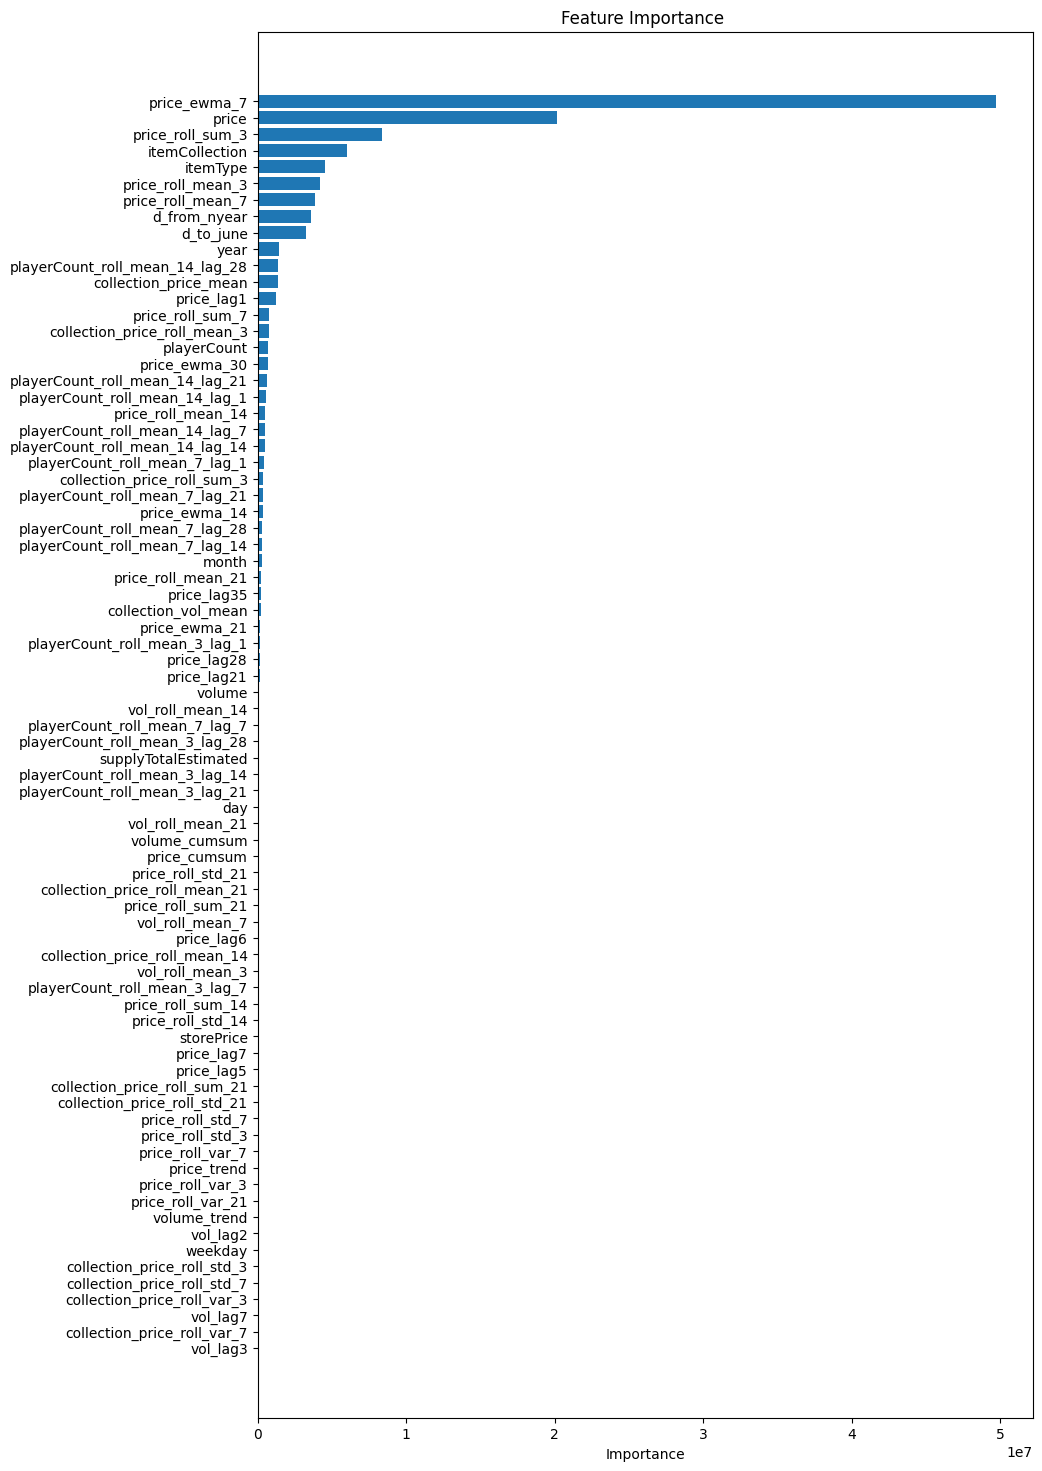

,Feature,Importance
53,price_ewma_7,4.969708e+07
0,price,2.018790e+07
35,price_roll_sum_3,8.385486e+06
6,itemCollection,6.052919e+06
5,itemType,4.559926e+06
32,price_roll_mean_3,4.195860e+06
36,price_roll_mean_7,3.837673e+06
76,d_from_nyear,3.611538e+06
77,d_to_june,3.290445e+06
71,year,1.463978e+06


In [62]:
trim=0
print_importances(model,trim,True,figsize=(10, 18),importance_type='gain')

In [54]:
#@title Analyzer

class Analyzer():
  def __init__(self,X,y,model=None,show=False):
    self.X = X
    self.y = y
    self.model = model
    self.selected_columns = ['volume', 'playerCount',
                    'supplyTotalEstimated', 'storePrice',
                    'itemType', 'itemCollection']
    self.create_dataset()
    self.group_data()
    self.add_info(show=show)

  def create_dataset(self):
    self.ds = self.X[self.selected_columns].copy()
    self.ds['target'] = self.y
    self.ds['pred'] = model.predict(self.X)

    self.ds['itemAE'] = (self.ds['target'] - self.ds['pred']).abs()
    self.ds['itemAPE'] = self.ds['itemAE'] / self.ds['target'].abs()

  def group_data(self):
    self.grouped = self.ds.groupby('name').agg(
      itemType=('itemType', 'first'),
      itemCollection=('itemCollection', 'first'),

      volume=('volume', 'mean'),
      playerCount=('playerCount', 'mean'),
      supplyTotalEstimated=('supplyTotalEstimated', 'mean'),
      storePrice=('storePrice', 'mean'),

      itemMAE=('itemAE', 'mean'),
      itemMedAE=('itemAE', 'median'),
      itemMAPE=('itemAPE', 'mean'),
      size=('target', 'size')
    )

  def add_info(self,show=False):
    self.item_counts = self.ds.groupby(['name']).size().reset_index(name='count')
    self.name_list = self.item_counts['count'].tolist()

    if show:
      print(f"X shape: {self.X.shape} y shape: {self.y.shape}")
      display(self.item_counts)

  def get_item_data(self,item_name):
    if item_name not in self.ds.index.get_level_values('name'):
      print(f"{item_name} is not in the given data")
      return None
    return self.ds.xs(item_name, level='name', drop_level=True)

  def analyze(self):
    ds = self.ds

  def plot(self,item_name,plot_name=None):
    if plot_name is None:
      plot_name = f"plot {item_name}"
    item_data = self.get_item_data(item_name)
    if item_data is None:
      return
    plot_pricehistory([item_data['pred'],item_data['target']],['pred','target'],plot_name)


In [55]:
analyzer = Analyzer(X,y,model,show=True)

X shape: (4784143, 78) y shape: (4784143,)


,name,count
0,60's Army Jacket,2637
1,8-BIT AR,476
2,AK Royale,1458
3,AK-47 From Hell,2157
4,AK-47 Victoria,2043
...,...,...
3758,Zombow,63
3759,Zucchini Furnace,513
3760,uMod Fundraiser Garage Door,1297
3761,Сhristmas Night,1820


In [56]:
analyzer_test = Analyzer(X_test,y_test,model,show=True)

X shape: (844261, 78) y shape: (844261,)


,name,count
0,60's Army Jacket,164
1,8-BIT AR,248
2,AK Royale,135
3,AK-47 From Hell,249
4,AK-47 Victoria,239
...,...,...
4116,Zombow,251
4117,Zucchini Furnace,254
4118,uMod Fundraiser Garage Door,254
4119,Сhristmas Night,221


In [26]:
X_test.shape

(844261, 78)

In [57]:
item_name="Whiteout Kilt"
analyzer.plot(item_name)
analyzer_test.plot(item_name)


In [61]:
item_name="Alien Red"
analyzer.plot(item_name)
analyzer_test.plot(item_name)


In [59]:
display(analyzer.get_item_data("Alien Red"))
display(analyzer_test.get_item_data("Alien Red"))
display(analyzer.get_item_data("Blackout Kilt"))
display(analyzer_test.get_item_data("Blackout Kilt"))

,volume,playerCount,supplyTotalEstimated,storePrice,itemType,itemCollection,target,pred,itemAE,itemAPE
date,,,,,,,,,,
2017-02-10,1,58707,3168,2.49,Assault Rifle,,3.150000,2.173424,0.976576,0.310024
2017-02-11,2,57663,3168,2.49,Assault Rifle,,3.162857,8.434263,5.271406,1.666660
2017-02-12,2,56619,3168,2.49,Assault Rifle,,3.172857,8.036986,4.864129,1.533044
2017-02-13,3,55575,3168,2.49,Assault Rifle,,3.197143,9.440678,6.243535,1.952848
2017-02-14,2,54531,3168,2.49,Assault Rifle,,3.158571,9.639227,6.480656,2.051768
...,...,...,...,...,...,...,...,...,...,...
2023-12-26,6,124265,3168,2.49,Assault Rifle,,149.684286,138.968301,10.715985,0.071591
2023-12-27,17,119025,3168,2.49,Assault Rifle,,149.048571,138.785025,10.263546,0.068860
2023-12-28,6,134431,3168,2.49,Assault Rifle,,150.325714,138.707205,11.618509,0.077289


,volume,playerCount,supplyTotalEstimated,storePrice,itemType,itemCollection,target,pred,itemAE,itemAPE
date,,,,,,,,,,
2023-12-31,7,98804,3168,2.49,Assault Rifle,,151.141429,155.477399,4.335970,0.028688
2024-01-01,12,190886,3168,2.49,Assault Rifle,,149.855714,151.324638,1.468924,0.009802
2024-01-02,7,125025,3168,2.49,Assault Rifle,,148.405714,142.968936,5.436778,0.036635
2024-01-03,5,109816,3168,2.49,Assault Rifle,,147.925714,143.022397,4.903317,0.033147
2024-01-04,12,190886,3168,2.49,Assault Rifle,,145.880000,151.516685,5.636685,0.038639
...,...,...,...,...,...,...,...,...,...,...
2024-09-04,6,69896,3168,2.49,Assault Rifle,,155.584286,168.106305,12.522019,0.080484
2024-09-05,4,129426,3168,2.49,Assault Rifle,,153.584286,168.110489,14.526204,0.094581
2024-09-06,3,125478,3168,2.49,Assault Rifle,,152.642857,168.221813,15.578956,0.102061


,volume,playerCount,supplyTotalEstimated,storePrice,itemType,itemCollection,target,pred,itemAE,itemAPE
date,,,,,,,,,,
2020-06-18,237,95909,44075,1.99,Road Sign Kilt,Blackout,4.157143,2.475621,1.681522,0.404490
2020-06-19,436,96050,44075,1.99,Road Sign Kilt,Blackout,4.198571,2.508084,1.690488,0.402634
2020-06-20,525,96191,44075,1.99,Road Sign Kilt,Blackout,4.245714,2.854611,1.391103,0.327649
2020-06-21,467,96332,44075,1.99,Road Sign Kilt,Blackout,4.292857,3.028721,1.264136,0.294474
2020-06-22,415,96473,44075,1.99,Road Sign Kilt,Blackout,4.334286,3.060121,1.274164,0.293973
...,...,...,...,...,...,...,...,...,...,...
2023-12-26,43,124265,44075,1.99,Road Sign Kilt,Blackout,13.504286,18.035075,4.530789,0.335507
2023-12-27,40,119025,44075,1.99,Road Sign Kilt,Blackout,13.351429,18.287506,4.936078,0.369704
2023-12-28,39,134431,44075,1.99,Road Sign Kilt,Blackout,13.378571,18.749730,5.371158,0.401475


,volume,playerCount,supplyTotalEstimated,storePrice,itemType,itemCollection,target,pred,itemAE,itemAPE
date,,,,,,,,,,
2023-12-31,28,98804,44075,1.99,Road Sign Kilt,Blackout,13.155714,18.649961,5.494247,0.417632
2024-01-01,29,190886,44075,1.99,Road Sign Kilt,Blackout,13.205714,16.535308,3.329594,0.252133
2024-01-02,29,125025,44075,1.99,Road Sign Kilt,Blackout,13.068571,16.288362,3.219791,0.246377
2024-01-03,27,109816,44075,1.99,Road Sign Kilt,Blackout,13.171429,16.450522,3.279094,0.248955
2024-01-04,36,190886,44075,1.99,Road Sign Kilt,Blackout,13.310000,16.355363,3.045363,0.228803
...,...,...,...,...,...,...,...,...,...,...
2024-09-04,31,69896,44075,1.99,Road Sign Kilt,Blackout,11.794286,11.255765,0.538521,0.045659
2024-09-05,24,129426,44075,1.99,Road Sign Kilt,Blackout,11.885714,11.678316,0.207398,0.017449
2024-09-06,16,125478,44075,1.99,Road Sign Kilt,Blackout,11.862857,11.556812,0.306045,0.025799


In [ ]:
from google.colab import runtime
runtime.unassign()